# Speech Emotion Recognition
# CNN Model

## 01) Importing Libraries

In [1]:
import sys
import os
import random
import math
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

SRC_PATH = "../"
if SRC_PATH not in sys.path:
    sys.path.append(os.path.abspath(SRC_PATH))

from data_utils import load_data_pt, stratified_split, loss_accuracy_graphs, train_epoch, evaluate

## 02) Setting Default Values

In [2]:
DATA_PATH = '../../data/extracted/ravdess_features_balanced_rebalanced.pt'
OUT_DIR = '../../models/CNN'

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 6

print(f"DATA_PATH : '{DATA_PATH}'")
print(f"OUT_DIR : '{OUT_DIR}'")
print(f"Device : {DEVICE}")

DATA_PATH : '../../data/extracted/ravdess_features_balanced_rebalanced.pt'
OUT_DIR : '../../models/CNN'
Device : cuda


## 03) Creating the CNN Model

In [3]:
class CNN1DClassifier(nn.Module):
    def __init__(self, feat_dim, n_time, n_classes=8):
        super().__init__()
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=feat_dim, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.convnet(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

## 04) Creating the Training Method for CNN Model

In [8]:
def train(X, y, meta, epochs, batch_size, lr):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    N, T, D = X.shape

    X_train, y_train, X_validation, y_validation, X_test, y_test = stratified_split(X, y)
    print("Splits: Train -", X_train.shape[0], ", Validation -", X_validation.shape[0], ", Test -", X_test.shape[0])

    train_dataset = TensorDataset(X_train, y_train)
    validation_dataset = TensorDataset(X_validation, y_validation)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    model = CNN1DClassifier(feat_dim=D, n_time=T, n_classes=8).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_validation = 0.0
    
    os.makedirs(OUT_DIR, exist_ok=True)
    patience = 0

    loss_accuracy_data =  {"epochs": [], "train_loss" : [], "train_accuracy" : [], "validation_loss" : [], "validation_accuracy" : []}

    for epoch in range(1, epochs+1):
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
        validation_loss, validation_accuracy = evaluate(model, validation_loader, criterion, DEVICE)

        loss_accuracy_data["epochs"].append(epoch)
        loss_accuracy_data["train_loss"].append(train_loss)
        loss_accuracy_data["train_accuracy"].append(train_accuracy)
        loss_accuracy_data["validation_loss"].append(validation_loss)
        loss_accuracy_data["validation_accuracy"].append(validation_accuracy)
        
        print(f"[CNN] Epoch {epoch} TrainLoss {train_loss:.4f} TrainAccuracy {train_accuracy:.4f} ValidationLoss {validation_loss:.4f} ValidationAccuracy {validation_accuracy:.4f}")
        if validation_accuracy > best_validation:
            best_validation = validation_accuracy
            best_model = model.state_dict()
            best_meta = meta
            patience = 0
        else:
            patience += 1
        if patience >= PATIENCE:
            print("Early stopping.")
            break

    loss_accuracy_graphs(loss_accuracy_data)
    
    return model.state_dict(), meta, best_model, best_meta, X_test, y_test

## 05) Load the Dataset

In [9]:
X, y, meta = load_data_pt(DATA_PATH)
print("Size of Loaded Data:", X.shape, "\nSize of Labels:", y.shape, "\nDevice:", DEVICE)

Size of Loaded Data: torch.Size([3072, 228, 180]) 
Size of Labels: torch.Size([3072]) 
Device: cuda


## 06) Training the Model with Different Hyperparameter Values

### (i) Training the Model with these Hyperparameter Values
- Epochs = 30
- Batch Size = 32
- Learning Rate = 1e-3 = 0.001

Splits: Train - 2457 , Validation - 307 , Test - 308
[CNN] Epoch 1 TrainLoss 1.6966 TrainAccuracy 0.3398 ValidationLoss 1.6337 ValidationAccuracy 0.3583
[CNN] Epoch 2 TrainLoss 1.3767 TrainAccuracy 0.4884 ValidationLoss 1.3617 ValidationAccuracy 0.4886
[CNN] Epoch 3 TrainLoss 1.2029 TrainAccuracy 0.5511 ValidationLoss 1.3730 ValidationAccuracy 0.5440
[CNN] Epoch 4 TrainLoss 1.0225 TrainAccuracy 0.6313 ValidationLoss 1.1011 ValidationAccuracy 0.5928
[CNN] Epoch 5 TrainLoss 0.9016 TrainAccuracy 0.6716 ValidationLoss 0.9188 ValidationAccuracy 0.6710
[CNN] Epoch 6 TrainLoss 0.8186 TrainAccuracy 0.7021 ValidationLoss 1.0186 ValidationAccuracy 0.6254
[CNN] Epoch 7 TrainLoss 0.7616 TrainAccuracy 0.7163 ValidationLoss 0.9715 ValidationAccuracy 0.6450
[CNN] Epoch 8 TrainLoss 0.6849 TrainAccuracy 0.7530 ValidationLoss 0.7352 ValidationAccuracy 0.7720
[CNN] Epoch 9 TrainLoss 0.5500 TrainAccuracy 0.8107 ValidationLoss 0.7283 ValidationAccuracy 0.7394
[CNN] Epoch 10 TrainLoss 0.4822 TrainAccuracy 0

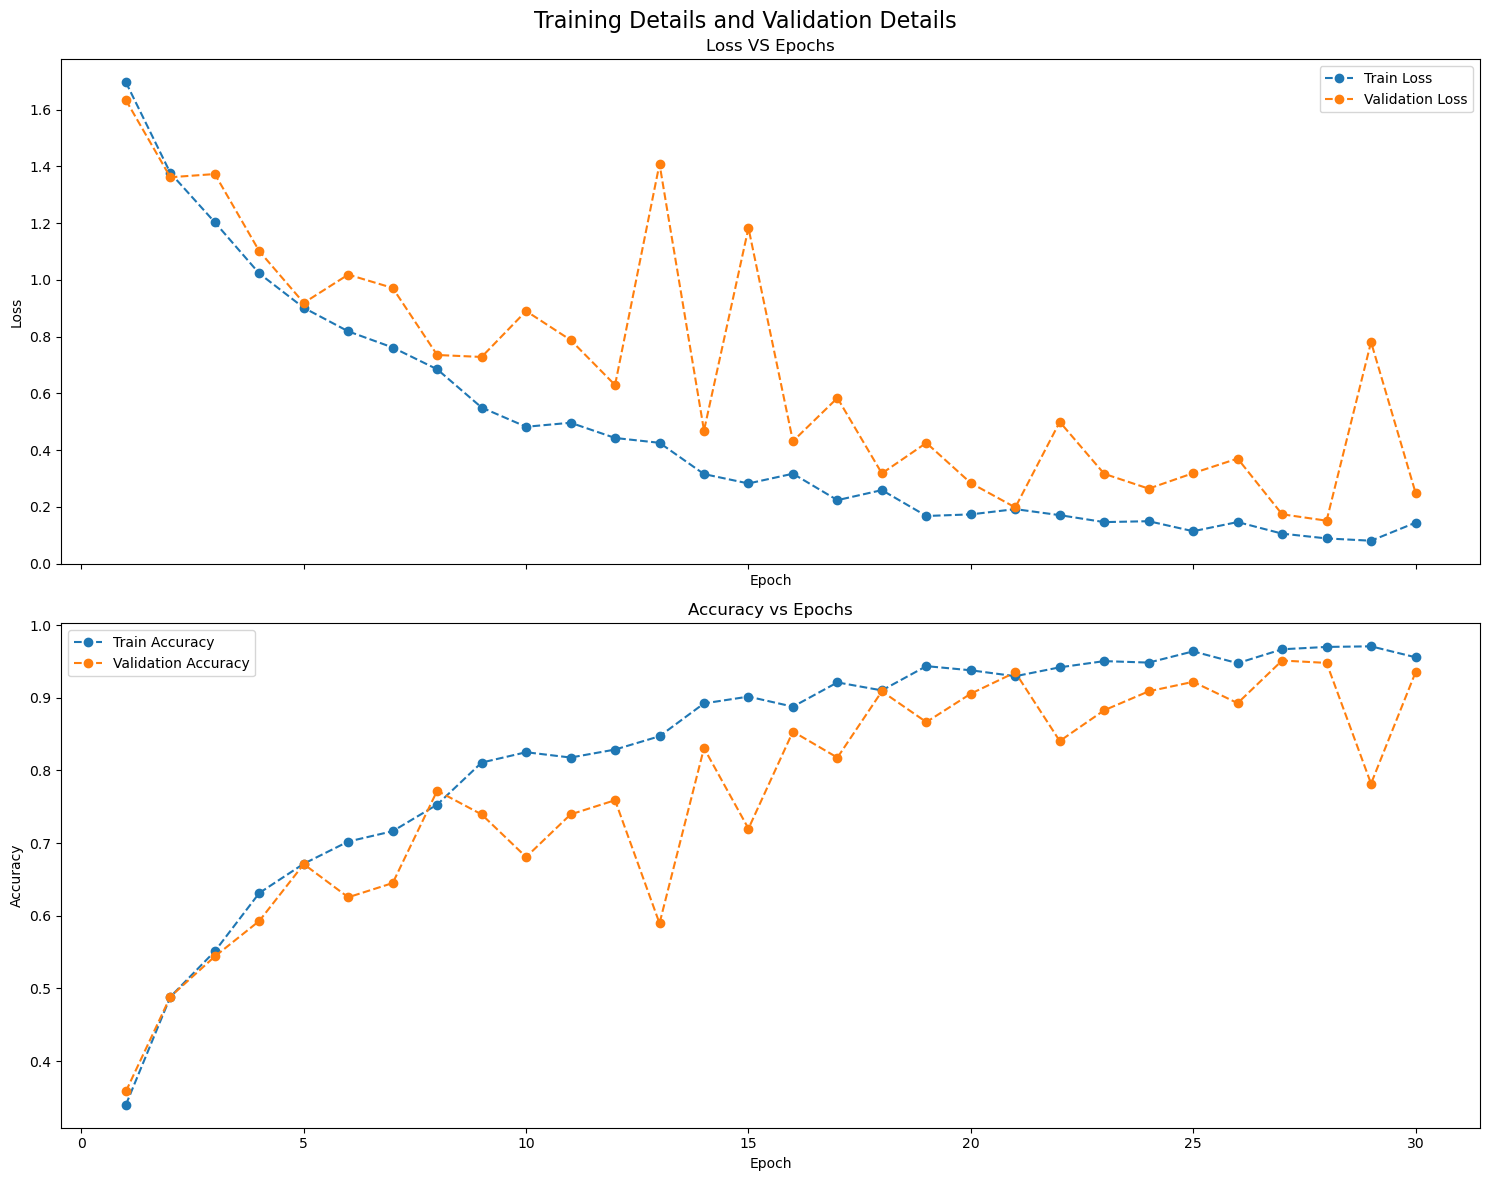

In [10]:
epochs = 30
batch_size = 32
lr = 1e-3
model_data, meta, best_model, best_meta, X_test, y_test= train(X, y, meta, epochs, batch_size, lr)

### (ii) Training the Model with these Hyperparameter Values
- Epochs = 30
- Batch Size = 64
- Learning Rate = 1e-3 = 0.001

Splits: Train - 2457 , Validation - 307 , Test - 308
[CNN] Epoch 1 TrainLoss 1.7151 TrainAccuracy 0.3236 ValidationLoss 1.5324 ValidationAccuracy 0.3876
[CNN] Epoch 2 TrainLoss 1.3387 TrainAccuracy 0.4957 ValidationLoss 1.4531 ValidationAccuracy 0.4137
[CNN] Epoch 3 TrainLoss 1.1354 TrainAccuracy 0.5779 ValidationLoss 1.1136 ValidationAccuracy 0.6124
[CNN] Epoch 4 TrainLoss 0.9709 TrainAccuracy 0.6418 ValidationLoss 0.9430 ValidationAccuracy 0.6645
[CNN] Epoch 5 TrainLoss 0.8662 TrainAccuracy 0.6891 ValidationLoss 0.9440 ValidationAccuracy 0.6645
[CNN] Epoch 6 TrainLoss 0.7249 TrainAccuracy 0.7399 ValidationLoss 0.9560 ValidationAccuracy 0.6612
[CNN] Epoch 7 TrainLoss 0.6733 TrainAccuracy 0.7578 ValidationLoss 0.7452 ValidationAccuracy 0.7264
[CNN] Epoch 8 TrainLoss 0.5887 TrainAccuracy 0.7867 ValidationLoss 1.9373 ValidationAccuracy 0.4919
[CNN] Epoch 9 TrainLoss 0.5130 TrainAccuracy 0.8152 ValidationLoss 0.5890 ValidationAccuracy 0.7752
[CNN] Epoch 10 TrainLoss 0.4970 TrainAccuracy 0

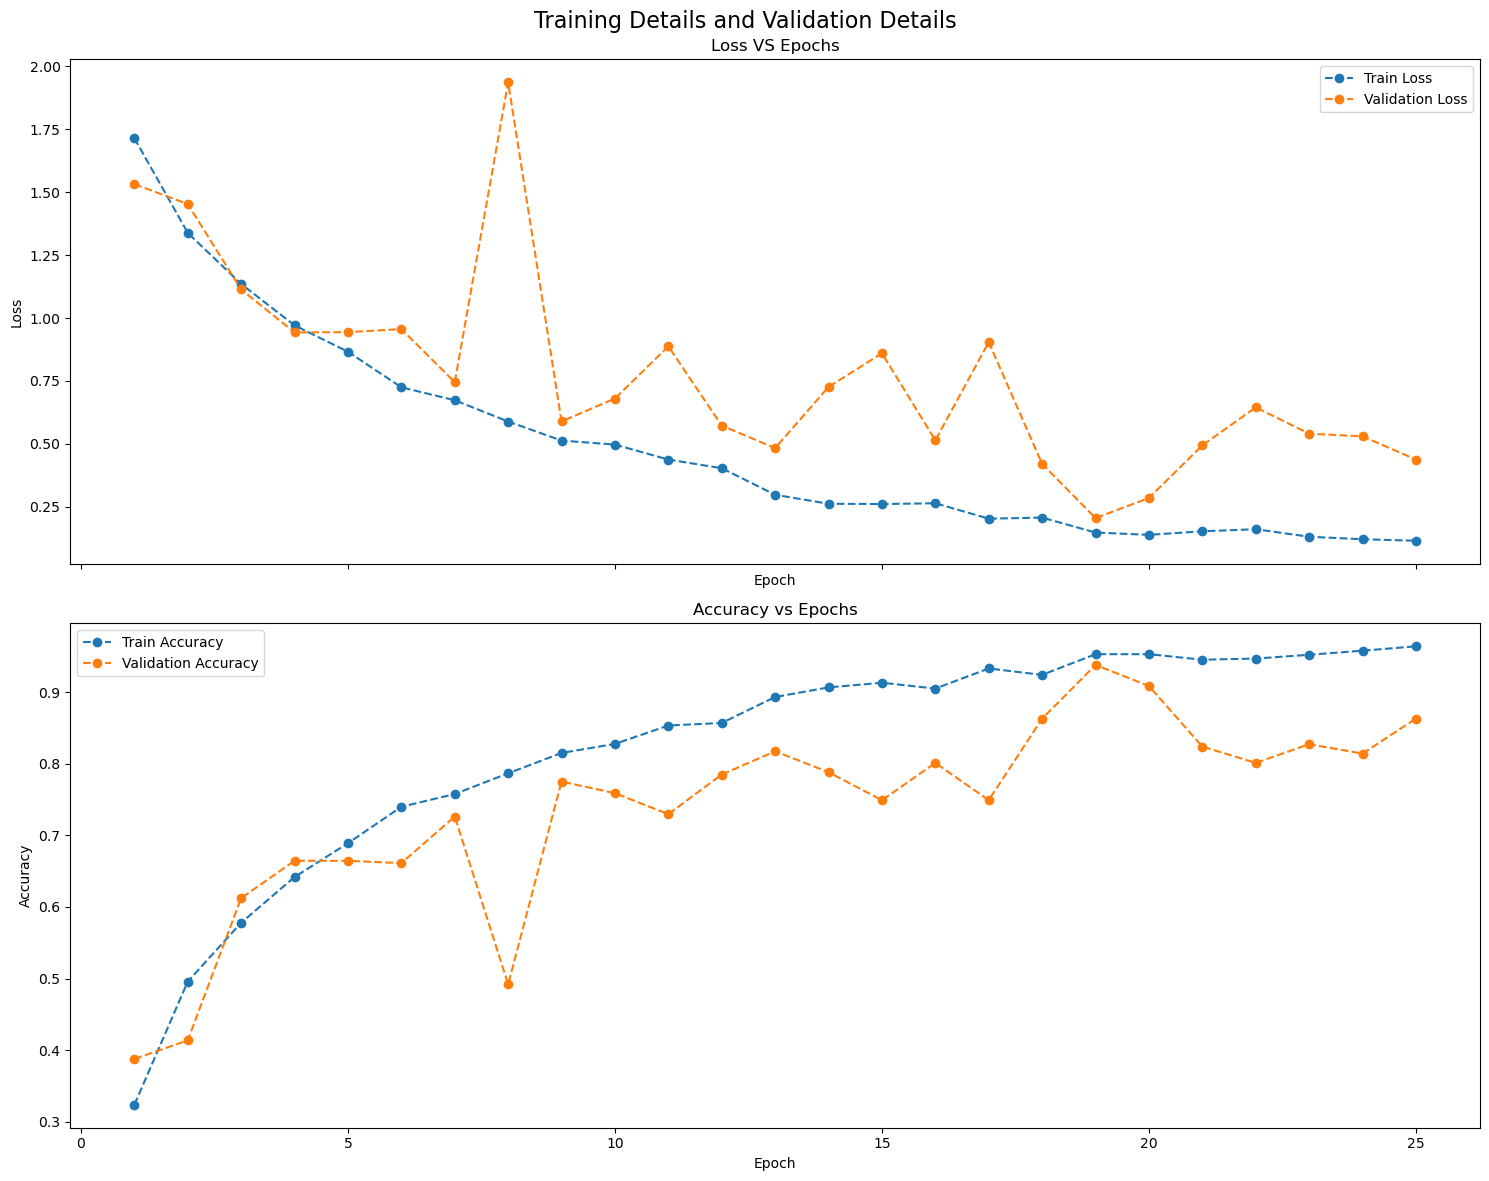

In [11]:
epochs = 30
batch_size = 64
lr = 1e-3
model_data, meta, best_model, best_meta, X_test, y_test= train(X, y, meta, epochs, batch_size, lr)

### (iii) Training the Model with these Hyperparameter Values
- Epochs = 40
- Batch Size = 32
- Learning Rate = 1e-3 = 0.001

Splits: Train - 2457 , Validation - 307 , Test - 308
[CNN] Epoch 1 TrainLoss 1.6966 TrainAccuracy 0.3398 ValidationLoss 1.6337 ValidationAccuracy 0.3583
[CNN] Epoch 2 TrainLoss 1.3767 TrainAccuracy 0.4884 ValidationLoss 1.3617 ValidationAccuracy 0.4886
[CNN] Epoch 3 TrainLoss 1.2029 TrainAccuracy 0.5511 ValidationLoss 1.3730 ValidationAccuracy 0.5440
[CNN] Epoch 4 TrainLoss 1.0225 TrainAccuracy 0.6313 ValidationLoss 1.1011 ValidationAccuracy 0.5928
[CNN] Epoch 5 TrainLoss 0.9016 TrainAccuracy 0.6716 ValidationLoss 0.9188 ValidationAccuracy 0.6710
[CNN] Epoch 6 TrainLoss 0.8186 TrainAccuracy 0.7021 ValidationLoss 1.0186 ValidationAccuracy 0.6254
[CNN] Epoch 7 TrainLoss 0.7616 TrainAccuracy 0.7163 ValidationLoss 0.9715 ValidationAccuracy 0.6450
[CNN] Epoch 8 TrainLoss 0.6849 TrainAccuracy 0.7530 ValidationLoss 0.7352 ValidationAccuracy 0.7720
[CNN] Epoch 9 TrainLoss 0.5500 TrainAccuracy 0.8107 ValidationLoss 0.7283 ValidationAccuracy 0.7394
[CNN] Epoch 10 TrainLoss 0.4822 TrainAccuracy 0

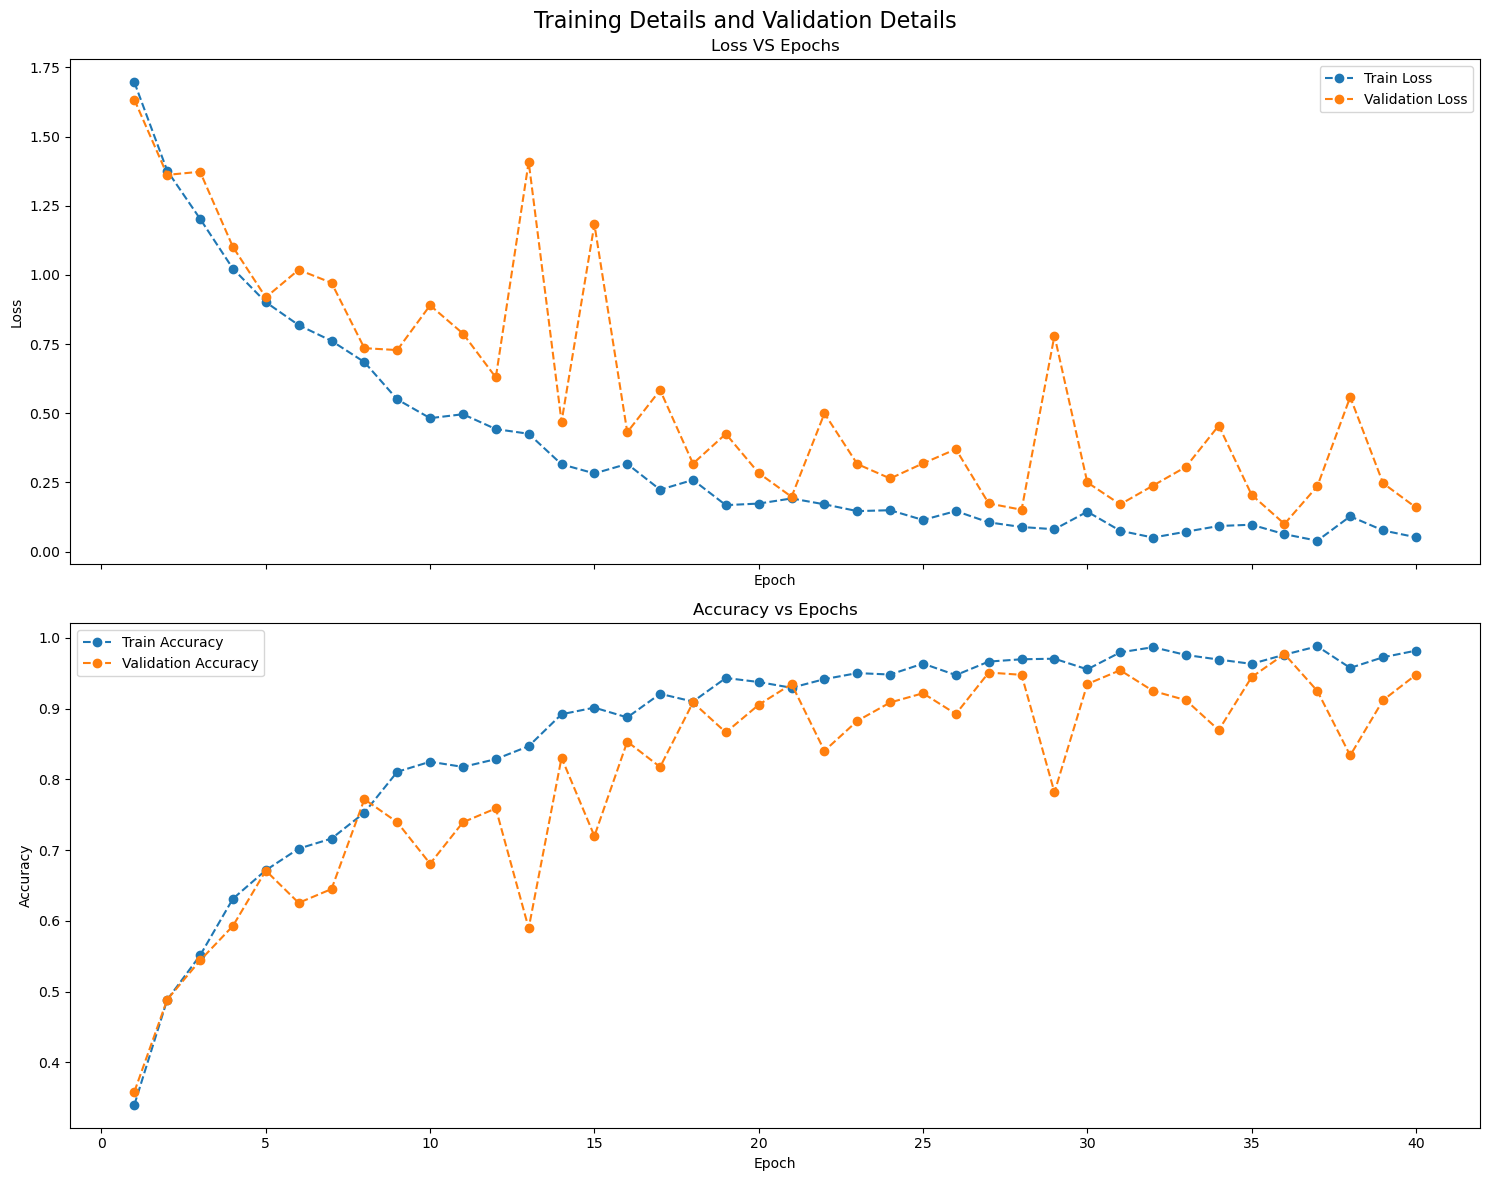

In [12]:
epochs = 40
batch_size = 32
lr = 1e-3
model_data, meta, best_model, best_meta, X_test, y_test= train(X, y, meta, epochs, batch_size, lr)

### (iv) Training the Model with these Hyperparameter Values
- Epochs = 30
- Batch Size = 32
- Learning Rate = 1e-4 = 0.0001

Splits: Train - 2457 , Validation - 307 , Test - 308
[CNN] Epoch 1 TrainLoss 1.8715 TrainAccuracy 0.3089 ValidationLoss 1.6910 ValidationAccuracy 0.4039
[CNN] Epoch 2 TrainLoss 1.5710 TrainAccuracy 0.4542 ValidationLoss 1.4745 ValidationAccuracy 0.4951
[CNN] Epoch 3 TrainLoss 1.3483 TrainAccuracy 0.5495 ValidationLoss 1.2866 ValidationAccuracy 0.5831
[CNN] Epoch 4 TrainLoss 1.1457 TrainAccuracy 0.6256 ValidationLoss 1.1014 ValidationAccuracy 0.6156
[CNN] Epoch 5 TrainLoss 0.9776 TrainAccuracy 0.6789 ValidationLoss 0.8892 ValidationAccuracy 0.7166
[CNN] Epoch 6 TrainLoss 0.8425 TrainAccuracy 0.7379 ValidationLoss 0.7722 ValidationAccuracy 0.7524
[CNN] Epoch 7 TrainLoss 0.7067 TrainAccuracy 0.7831 ValidationLoss 0.6949 ValidationAccuracy 0.7915
[CNN] Epoch 8 TrainLoss 0.5889 TrainAccuracy 0.8221 ValidationLoss 0.6732 ValidationAccuracy 0.7948
[CNN] Epoch 9 TrainLoss 0.4770 TrainAccuracy 0.8669 ValidationLoss 0.6030 ValidationAccuracy 0.7980
[CNN] Epoch 10 TrainLoss 0.4052 TrainAccuracy 0

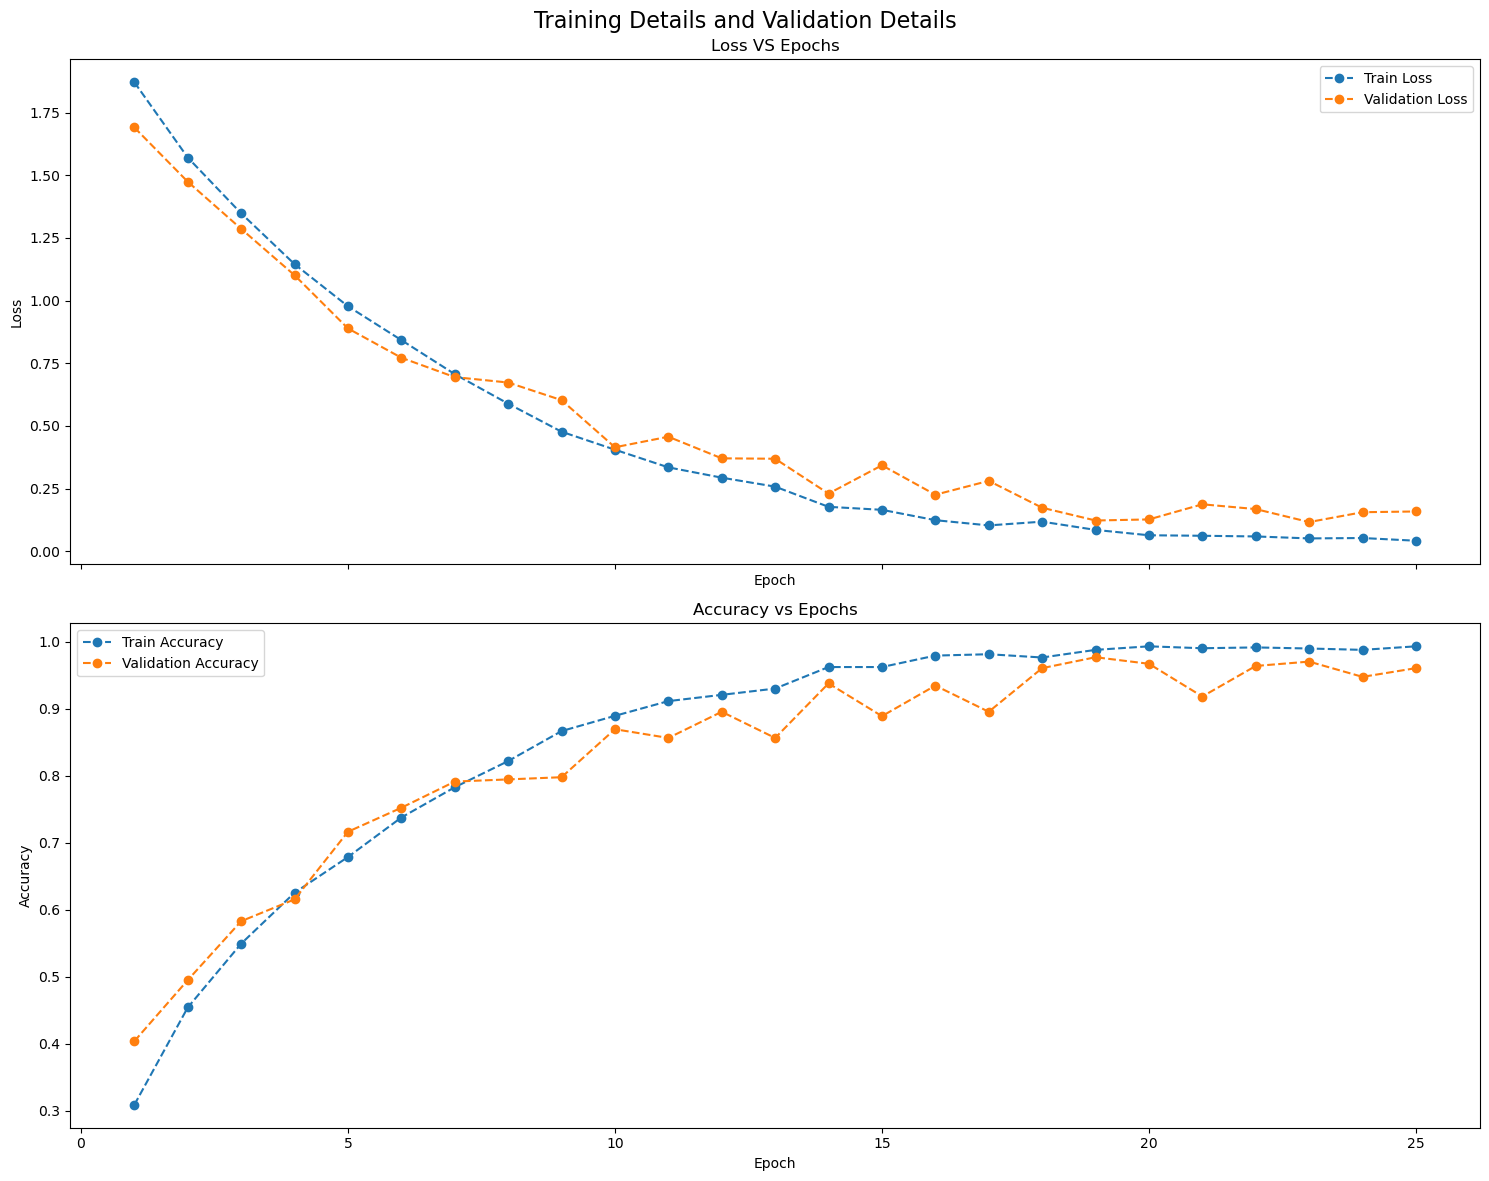

In [14]:
epochs = 30
batch_size = 32
lr = 1e-4
model_data, meta, best_model, best_meta, X_test, y_test= train(X, y, meta, epochs, batch_size, lr)

#### By Observing all the Graphs, (iv) is the model with the Best Hyperparameter Values
#### Therefore,
- Best Epochs = 30
- Best Batch Size = 32
- Best Learning Rate = 1e-4 = 0.0001

## 06) Saving the Models with Best Hyperparameter Values

In [15]:
best_path = os.path.join(OUT_DIR, "cnn_best.pt")
torch.save({'state_dict': model_data, 'meta': meta}, best_path)
print(f"Saved Best Model:, '{best_path}'")

save_path = os.path.join(OUT_DIR, "cnn.pt")
torch.save({'state_dict': model_data, 'meta': meta}, save_path)
print(f"Saved Best Model:, '{save_path}")

Saved Best Model:, '../../models/CNN/cnn_best.pt'
Saved Best Model:, '../../models/CNN/cnn.pt


## 07) Evaluating the CNN Model with Test Set of Data

In [16]:
def evaluate_model(X, y, meta, X_test, y_test):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    N, T, D = X.shape
    model = CNN1DClassifier(feat_dim=D, n_time=T, n_classes=8).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    model.load_state_dict(torch.load(best_path, map_location=DEVICE)['state_dict'])
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    total_loss = 0.0
    total = 0
    correct = 0
    all_preds = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    test_loss = total_loss/total
    test_accuracy = correct/total

    total_accuracy_score = accuracy_score(y_test, all_preds)
    full_classification_report = classification_report(y_test, all_preds, digits=4)
    final_f1_score = f1_score(y_test, all_preds, average='macro', zero_division=0)
    return test_loss, total_accuracy_score, final_f1_score, full_classification_report, all_preds

## 08) Accuracy, Classification Report and Confusion Matrix

--------Test Set Performance--------

Test Loss: 0.14503613191765624
Accuracy: 0.9675324675324676
Macro F1 Score: 0.9668330105625567


--------Classification Report--------

               precision    recall  f1-score   support

           0     0.9744    1.0000    0.9870        38
           1     1.0000    1.0000    1.0000        38
           2     0.9024    0.9737    0.9367        38
           3     1.0000    1.0000    1.0000        39
           4     0.9750    1.0000    0.9873        39
           5     0.9070    1.0000    0.9512        39
           6     1.0000    0.9737    0.9867        38
           7     1.0000    0.7949    0.8857        39

    accuracy                         0.9675       308
   macro avg     0.9698    0.9678    0.9668       308
weighted avg     0.9699    0.9675    0.9667       308



--------Confusion Maxtrix--------


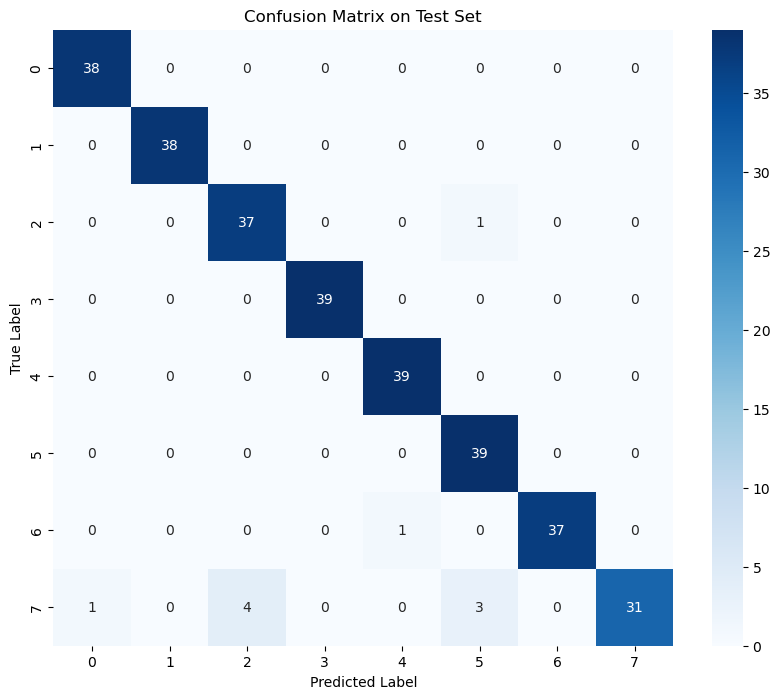

In [17]:
test_loss, total_accuracy_score, final_f1_score, full_classification_report, all_preds =  evaluate_model(X, y, meta, X_test, y_test)
print("--------Test Set Performance--------")
print(f"\nTest Loss: {test_loss}")
print(f"Accuracy: {total_accuracy_score}")
print(f"Macro F1 Score: {final_f1_score}\n\n")
print(f"--------Classification Report--------\n\n {full_classification_report}\n\n")

print("--------Confusion Maxtrix--------")
final_confusion_matrix = confusion_matrix(y_test, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(final_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()